In [1]:
import ipdb
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import os
import pickletools
from grid2op import Episode
from collections import namedtuple, Counter
import random

from typing import Union, List, Tuple, Optional
import imitation_data_loading
from imitation_data_loading import preprocess_observation, action_identificator, Episode, EpisodeStep, EpisodeSet, StepSet
import grid2op_data_loading
import torch
from grid2op.PlotGrid import PlotMatplot
from grid2op import make
import grid2op
from anytree import Node, RenderTree
import anytree
import hashlib
import util

ModuleNotFoundError: No module named 'Action_space_auto_realistic'

In [2]:
f
DATA_PATH='./Data/sample_training_episodes'

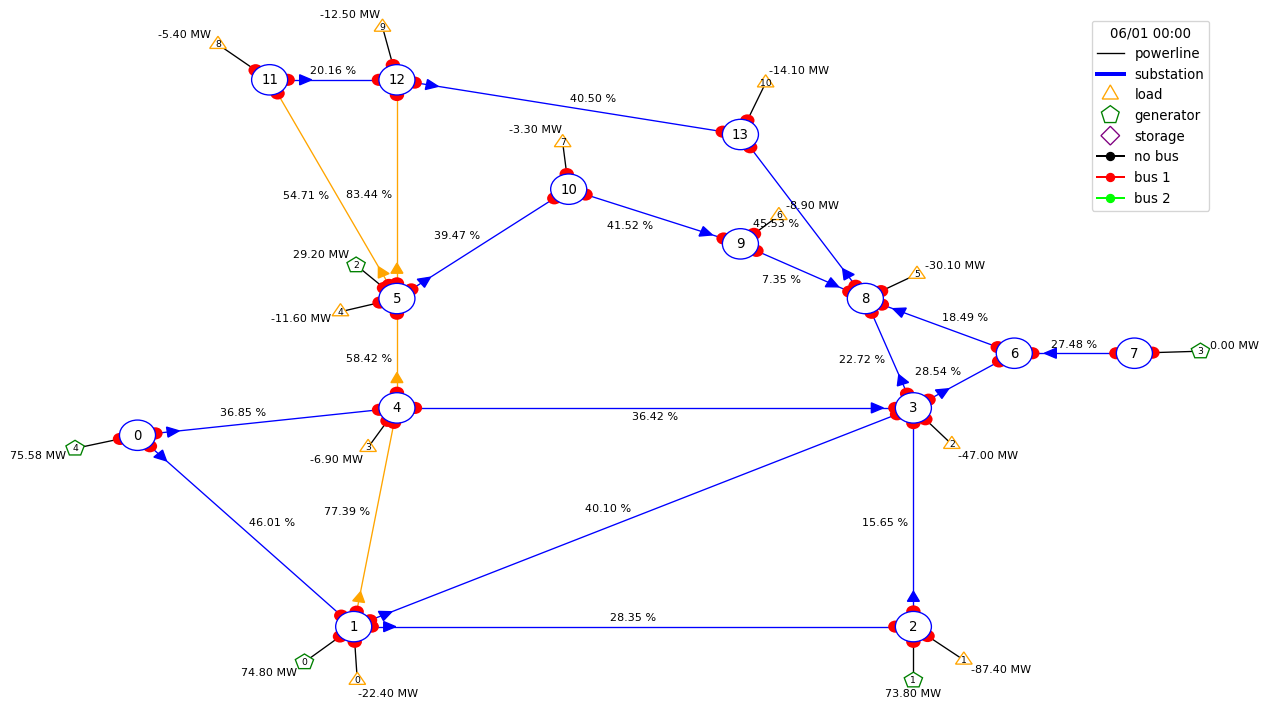

In [13]:
# Initialize the env.
env = make("rte_case14_realistic")
obs_space = env.observation_space

plot_helper = PlotMatplot(env.observation_space)

obs = env.reset()
fig = plot_helper.plot_obs(obs)

In [15]:

def get_changes(topo_vect,act):
    '''
    Given the current topology vector and a vector representing 'set' actions, 
    finds which object connections have changed.
    
    Parameters
    ----------
    topo_vect: np.array[int]
        The vector representing the current object connections. Each int represents the connection of a 
        single object to a busbar.
        A value of -1 indicates no connection; 1 a connection to the first busbar; 2 to the second busbar.
    act : np.array[int]
        A vector representing 'set' actions. Each int represent an action on an object-busbar connection.
        0 represents no change; 1 represents a set to the first busbar; 2 to the second.

    Returns
    -------
    set_idxs : np.array[int]
        Indices of set object-busbar connections.
    segt_objects : np.array[int]
        The busbar-object connections that have been set in the imitation example, 
        and whether that 'set' action caused a change. 0 represents no change; 1, change.
        The vector only represents the objects indexed by 'set_idxs'.
    any_changes : bool
        Whether the action changed any busbar-object connection.
    '''
    assert topo_vect.shape == act.shape
    assert all([x in [-1,1,2] for x in topo_vect])
    assert all([x in [0,1,2] for x in act])
        
    set_idxs = np.nonzero(act)[0]
    set_objects = np.abs(topo_vect[set_idxs] - act[set_idxs])
    any_changes = (np.count_nonzero(set_objects)!=0)
    return set_idxs, set_objects, any_changes

def custom_loss(out, set_idxs, changed_objects, any_changes,w_any=1,w_no=0.00):
    '''
    Custom loss
    '''
    if any_changes:
        return w_any*torch.nn.BCELoss()(out[set_idxs], changed_objects.float())
    else:
        return w_no*torch.nn.BCELoss()(out,torch.zeros(out.shape,device=device))
    
act_ider = action_identificator()

# Comparing rte_case14_realistic to L2rpn_case14_sandbox

Text(0.5, 1.0, 'Sum of generators P for rte_case14_realistic')

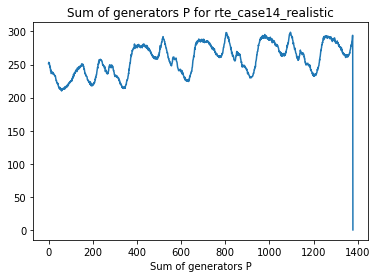

In [38]:
env = make("rte_case14_realistic")
obs_space = env.observation_space
obs = env.reset()
done=False

sum_gen_p = []
max_line_rho = []
while not done:
    action = env.action_space()  # create an action
    action.set_bus = []
    obs, reward, done, _ = env.step(action)
    sum_gen_p.append(sum(obs.gen_p))
    max_line_rho.append(max(obs.rho))
    
plt.plot(sum_gen_p)
plt.xlabel('Timestep')
plt.xlabel('Sum of generators P')
plt.title('Sum of generators P for rte_case14_realistic')

Text(0.5, 1.0, 'Maximum rho over time for rte_case14_realistic')

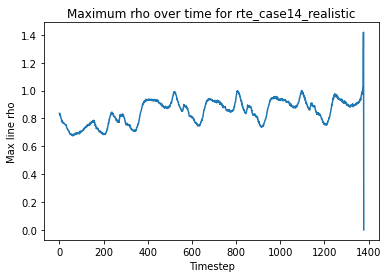

In [39]:
plt.plot(max_line_rho)
plt.xlabel('Timestep')
plt.ylabel('Max line rho')
plt.title('Maximum rho over time for rte_case14_realistic')

Text(0.5, 1.0, 'Sum of generators P for l2rpn_case14_sandbox')

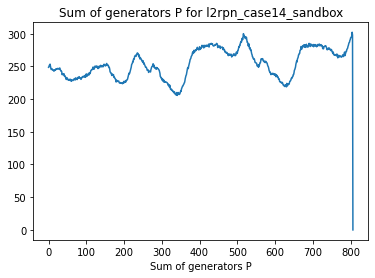

In [40]:
env = make("l2rpn_case14_sandbox")
obs_space = env.observation_space
obs = env.reset()
done=False

sum_gen_p = []
max_line_rho = []
while not done:
    action = env.action_space()  # create an action
    action.set_bus = []
    obs, reward, done, _ = env.step(action)
    sum_gen_p.append(sum(obs.gen_p))
    max_line_rho.append(max(obs.rho))
    
plt.plot(sum_gen_p)
plt.xlabel('Timestep')
plt.xlabel('Sum of generators P')
plt.title('Sum of generators P for l2rpn_case14_sandbox')

Text(0.5, 1.0, 'Maximum rho over time for l2rpn_case14_sandbox')

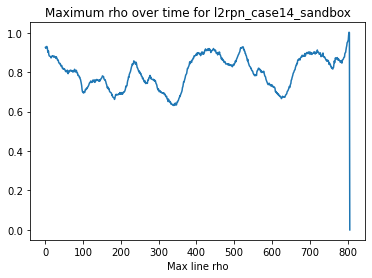

In [41]:
plt.plot(max_line_rho)
plt.xlabel('Timestep')
plt.xlabel('Max line rho')
plt.title('Maximum rho over time for l2rpn_case14_sandbox')

# Finding the right chronic

In [4]:
episodes = EpisodeSet(DATA_PATH)
ep_0_timestep_0_features = imitation_data_loading.parse_observation(episodes.get(0).steps[0].observation,5,11,20)
ep_0_timestep_0_features_gens = ep_0_timestep_0_features[0].astype(np.float32)

In [94]:
env = make("rte_case14_realistic")
obs_space = env.observation_space
n_chronics = len(env.chronics_handler.subpaths)

In [95]:
for i in range(n_chronics):
    obs = env.reset()
    env.set_id(i)
    if np.array_equal(ep_0_timestep_0_features_gens,grid2op_data_loading.extract_gen_features(obs)[1]):
        print(f'FOUND ##################################3333 {i}')
    else:
        print(f'NOT FOUND {i,np.mean(ep_0_timestep_0_features_gens-grid2op_data_loading.extract_gen_features(obs)[1])}')

NOT FOUND (0, 0.9746603)
NOT FOUND (1, 0.6728377)
NOT FOUND (2, 0.9746603)
NOT FOUND (3, 0.7700132)
NOT FOUND (4, 1.36955)
NOT FOUND (5, 1.6528115)
NOT FOUND (6, 1.143446)
NOT FOUND (7, 1.5236655)
NOT FOUND (8, 0.4381232)
NOT FOUND (9, 0.9682329)
NOT FOUND (10, 2.1648095)
NOT FOUND (11, 2.005584)
NOT FOUND (12, 1.0719279)
NOT FOUND (13, 1.6264013)
NOT FOUND (14, 0.37211037)
NOT FOUND (15, 2.1261735)
NOT FOUND (16, 1.2997681)
NOT FOUND (17, 0.63726324)
NOT FOUND (18, 1.6872857)
NOT FOUND (19, 1.0791187)
NOT FOUND (20, 1.7203516)
NOT FOUND (21, 1.2282751)
NOT FOUND (22, 1.7461039)
NOT FOUND (23, 1.2905098)
NOT FOUND (24, 2.1469798)
NOT FOUND (25, 0.56227213)
NOT FOUND (26, 1.5237237)
NOT FOUND (27, 1.0312982)
NOT FOUND (28, 0.9449589)
NOT FOUND (29, -0.33576635)
NOT FOUND (30, 0.97473824)
NOT FOUND (31, 1.4827976)
NOT FOUND (32, 1.2632638)
NOT FOUND (33, 0.91038525)
NOT FOUND (34, 1.2822961)
NOT FOUND (35, 1.0823005)
NOT FOUND (36, 1.3988605)
NOT FOUND (37, 0.051305644)
NOT FOUND (38, 1.

NOT FOUND (306, 0.047969308)
NOT FOUND (307, 1.3443811)
NOT FOUND (308, 0.24452311)
NOT FOUND (309, 0.8866572)
NOT FOUND (310, 0.82715404)
NOT FOUND (311, 1.90388)
NOT FOUND (312, 0.40529034)
NOT FOUND (313, 1.2952682)
NOT FOUND (314, 2.071076)
NOT FOUND (315, 0.63408667)
NOT FOUND (316, 1.9015002)
NOT FOUND (317, 1.2832435)
NOT FOUND (318, 1.0603902)
NOT FOUND (319, 0.63142014)
NOT FOUND (320, 1.417365)
NOT FOUND (321, 0.20710093)
NOT FOUND (322, 1.2873484)
NOT FOUND (323, 1.1873907)
NOT FOUND (324, 1.2509961)
NOT FOUND (325, 0.6173785)
NOT FOUND (326, 1.0427837)
NOT FOUND (327, 0.86312675)
NOT FOUND (328, 1.033748)
NOT FOUND (329, 0.31146532)
NOT FOUND (330, 0.960418)
NOT FOUND (331, 0.778322)
NOT FOUND (332, 1.4426326)
NOT FOUND (333, 1.0465491)
NOT FOUND (334, 0.7457777)
NOT FOUND (335, 1.4340026)
NOT FOUND (336, 1.4714218)
NOT FOUND (337, 1.4223505)
NOT FOUND (338, 0.55266184)
NOT FOUND (339, 0.66050637)
NOT FOUND (340, 1.35477)
NOT FOUND (341, 0.17868048)
NOT FOUND (342, 2.414002

NOT FOUND (608, 0.57337385)
NOT FOUND (609, 1.3256038)
NOT FOUND (610, 1.3009571)
NOT FOUND (611, 0.027739335)
NOT FOUND (612, 0.6102417)
NOT FOUND (613, 0.79296595)
NOT FOUND (614, 0.37436855)
NOT FOUND (615, 1.7869925)
NOT FOUND (616, 0.22666855)
NOT FOUND (617, 0.7108459)
NOT FOUND (618, 1.3053242)
NOT FOUND (619, 1.1301221)
NOT FOUND (620, 2.377555)
NOT FOUND (621, 0.9164859)
NOT FOUND (622, 0.42707235)
NOT FOUND (623, 0.81749463)
NOT FOUND (624, 0.8734428)
NOT FOUND (625, 0.76947695)
NOT FOUND (626, 0.8824046)
NOT FOUND (627, 0.7855661)
NOT FOUND (628, 0.84205073)
NOT FOUND (629, 0.6259013)
NOT FOUND (630, 0.9976024)
NOT FOUND (631, 1.6800802)
NOT FOUND (632, 0.35504696)
NOT FOUND (633, 1.3580331)
NOT FOUND (634, 1.0298085)
NOT FOUND (635, 1.6245654)
NOT FOUND (636, 1.8073537)
NOT FOUND (637, 1.567013)
NOT FOUND (638, 1.2811042)
NOT FOUND (639, 1.2592522)
NOT FOUND (640, 0.11134332)
NOT FOUND (641, 1.4420043)
NOT FOUND (642, 1.1856859)
NOT FOUND (643, -0.0869896)
NOT FOUND (644, 1

NOT FOUND (911, 1.0965145)
NOT FOUND (912, 0.59252816)
NOT FOUND (913, 0.5143748)
NOT FOUND (914, 1.3129517)
NOT FOUND (915, 0.3147473)
NOT FOUND (916, 0.48921803)
NOT FOUND (917, 1.6950887)
NOT FOUND (918, 0.5803951)
NOT FOUND (919, 0.5259794)
NOT FOUND (920, 0.6938198)
NOT FOUND (921, 0.8424653)
NOT FOUND (922, 1.1586671)
NOT FOUND (923, 1.0088599)
NOT FOUND (924, 1.1499661)
NOT FOUND (925, 1.2040585)
NOT FOUND (926, 0.55032337)
NOT FOUND (927, 0.89481795)
NOT FOUND (928, 0.9197578)
NOT FOUND (929, 1.9685315)
NOT FOUND (930, 2.080549)
NOT FOUND (931, 0.58374494)
NOT FOUND (932, 1.1116608)
NOT FOUND (933, 0.22592913)
NOT FOUND (934, 0.80549604)
NOT FOUND (935, 1.8365752)
NOT FOUND (936, 1.0485989)
NOT FOUND (937, 0.9644355)
NOT FOUND (938, 1.5974065)
NOT FOUND (939, 1.5913467)
NOT FOUND (940, 1.1526283)
NOT FOUND (941, 1.1354325)
NOT FOUND (942, 0.8399174)
NOT FOUND (943, 1.4258506)
NOT FOUND (944, 1.2540361)
NOT FOUND (945, 0.7276494)
NOT FOUND (946, 0.6684835)
NOT FOUND (947, 1.5020

In [18]:
imitation_data_loading.parse_observation(episodes.get(0).steps[1].observation,5,11,20)[5].astype(np.int32)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [15]:
abs(imitation_data_loading.parse_observation(episodes.get(0).steps[0].observation,5,11,20)[5]
    -imitation_data_loading.parse_observation(episodes.get(0).steps[1].observation,5,11,20)[5]).astype(np.int32)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [13]:
act_ider = imitation_data_loading.action_identificator()
act_ider.get_set_topo_vect(episodes.get(0).steps[0].action)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

# Generating tree structure

In [18]:
root = Node

def hash_obs(obs,act):
    h = hashlib.sha3_512()
    h.update(obs.data)
    h.update(str(act).encode())
    return h.hexdigest()

root = Node("start")


for ei in range(episodes.len()):
    ep = episodes.get(ei)
    par = root
    for si, s in enumerate(ep.steps):
        obs = s.observation
        act = s.action
        name = act#hash_obs(obs,act)
        
        data = preprocess_observation(obs,env.observation_space)
        
        siblings = par.children
        existing_node = [s for s in par.children if s.name==name]
        if not existing_node:
            same_as_par = None if par == root else np.array_equal(data[4], par.data[4])
            par = Node(name,parent=par,count=1,data=data,same_as_par=same_as_par,ind=(ei,si),act=act)
        else:
            par = existing_node[0]
            par.count+=1

In [19]:
depth = max([node.depth for node in anytree.PreOrderIter(root.children[0])])
N_total_timesteps = sum([node.count for node in anytree.PreOrderIter(root.children[0])])
N_timesteps_diff_par = sum([node.count for node in anytree.PreOrderIter(root.children[0]) if not node.same_as_par])
N_actions=112

# Inspecting tree branching

Text(0.5, 1.0, 'Distribution of episodes over branches over timesteps')

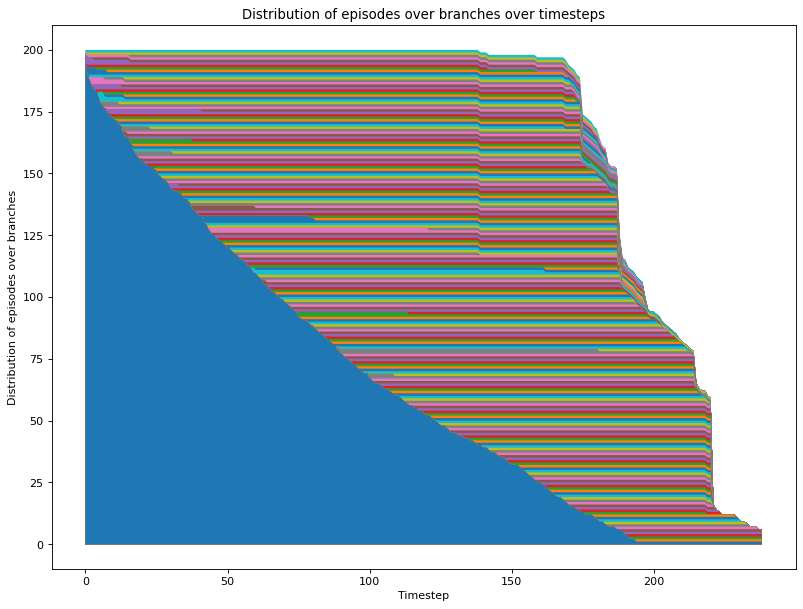

In [20]:
paths = [l.path[1:] for l in root.leaves]
#Sort paths by their size; we want larger paths in the front
paths.sort(key=lambda p: sum([n.count for n in p if n!=root]),reverse=True) 
visited_nodes = []
visited_nr = depth*[0]

plt.figure(figsize=(12, 9), dpi=80)
for i_p,p in enumerate(paths):
    node_counts = [(n.count if (n not in visited_nodes) else 0) for n in p]
    for i,c in enumerate(node_counts):
        visited_nr[i] += c

    plt.fill_between(y1=visited_nr,x=range(depth),zorder=-i_p)
    visited_nodes.extend(p)
    visited_nodes = list(set(visited_nodes))
        
plt.ylabel('Distribution of episodes over branches')
plt.xlabel('Timestep')
plt.title('Distribution of episodes over branches over timesteps')

# Inspecting actions

In [21]:
n_acts_per_step = {}
for n in anytree.PreOrderIter(root.children[0]):
    if n.act in n_acts_per_step  .keys():
        n_acts_per_step [n.act][n.depth-1] += n.count
    else:
        n_acts_per_step [n.act] = (depth)*[0]
        n_acts_per_step [n.act][n.depth-1] += n.count

In [22]:
list(zip(n_acts_per_step.keys(),[sum(v) for v in n_acts_per_step.values()]))

[(100, 38322),
 (50, 625),
 (103, 6),
 (58, 2),
 (22, 68),
 (106, 16),
 (27, 3),
 (110, 14),
 (25, 2),
 (0, 2),
 (48, 1),
 (20, 1),
 (12, 1),
 (49, 1)]

Text(0.5, 1.0, '# times an action was selected over the timesteps')

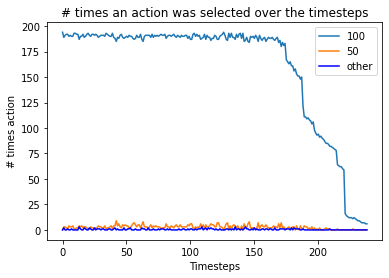

In [247]:
plt.plot(n_acts_per_step[100],label=100)
plt.plot(n_acts_per_step[50],label=50)
plt.plot(np.sum([v for k,v in n_acts_per_step.items() if not k in (100,50)],axis=0),c='b',label='other')
plt.legend()
plt.ylabel('# times action')
plt.xlabel('Timesteps')
plt.title('# times an action was selected over the timesteps')

In [297]:
n_acts_per_ds_step = {}
for n in anytree.PreOrderIter(root.children[0],
                              filter_=lambda n: (n.same_as_par is not None) and not n.same_as_par):
    if n.parent.act in n_acts_per_ds_step.keys():
        n_acts_per_ds_step[n.parent.act][n.depth-2] += n.count
    else:
        n_acts_per_ds_step[n.parent.act] = (depth-1)*[0]
        n_acts_per_ds_step[n.parent.act][n.depth-2] += n.count

In [298]:
list(zip(n_per_action.keys(),[sum(v) for v in n_per_action.values()]))

[(100, 200),
 (50, 195),
 (103, 6),
 (58, 2),
 (22, 28),
 (27, 3),
 (48, 1),
 (20, 1),
 (12, 1),
 (25, 1),
 (49, 1)]

Text(0.5, 1.0, '# times a do-something  action was selected over the non-first timesteps')

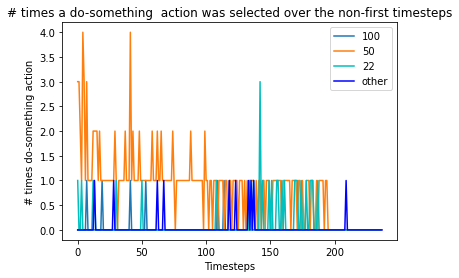

In [299]:
plt.plot(n_per_action[100][1:],label=100)
plt.plot(n_per_action[50][1:],label=50)
plt.plot(n_per_action[22][1:],label=22,c='c')
plt.plot(np.sum([v for k,v in n_per_action.items() if not k in (100,50,22)][1:],axis=0),c='b',label='other')
plt.legend()
plt.ylabel('# times do-something action')
plt.xlabel('Timesteps')
plt.title('# times a do-something  action was selected over the non-first timesteps')

In [313]:
np.mean([50 in [n.act for n in p] for p in paths])

1.0

In [315]:
np.mean([22 in [n.act for n in p] for p in paths])

0.15

# Entropy 

In [44]:
from scipy.stats import entropy

def count_entropy(children):
    return entropy([c.count for c in children])
mean_entropy=np.mean([count_entropy(node.children) for node in anytree.PreOrderIter(root.children[0])])
mean_weighted_entropy=sum([node.count*count_entropy(node.children)
                         for node in anytree.PreOrderIter(root.children[0])])/N_total_timesteps
mean_weighted_entropy_excl_noaction=sum([node.count*count_entropy([c for c in node.children if not c.same_as_par]) 
                               for node in anytree.PreOrderIter(root.children[0]) ])/sum([node.count for node in anytree.PreOrderIter(root.children[0]) if not node.same_as_par ])

In [46]:
mean_entropy

0.0014722986212321314

In [49]:
entropy([1,0.01])

0.05554607526889177

In [ ]:
act_ider = imitation_data_loading.action_identificator()


In [ ]:
from collections import Counter
Counter([i[1] for i in lst]).most_common()

In [ ]:
len(Counter([i[1] for i in lst]))

In [ ]:
imitation_data_loading 

model.train()
for e in range(n_epoch):
    i=0
    for step in imitation_data_loading.DataIterator(DATA_PATH):
        _,step_attr = step
        obs = step_attr.observation
        act = act_ider.get_set_topo_vect(step_attr.action)
        
        
        X_gen, X_load, X_or, X_ex, topo_vect, connectivity_edges = \
              preprocess_observation(obs,env.observation_space)
        set_idxs, set_objects, any_changes = get_changes(topo_vect,act)
        
        X_gen, X_load, X_or, X_ex = \
                [torch.tensor(x,device=device,dtype=torch.float) for x in (X_gen, X_load, X_or, X_ex)]
        topo_vect, connectivity_edges, act, set_objects = \
                [torch.tensor(x,device=device,dtype=torch.long) for x in (topo_vect, connectivity_edges, 
                                                                          act,set_objects)]
        
        out = model(X_gen, X_load, X_or, X_ex, connectivity_edges).reshape((-1))
        loss = custom_loss(out, set_idxs, set_objects, any_changes)
        loss.backward()
        optimizer.step()
        
        metrics.log(any_changes=any_changes,out=out,set_idxs=set_idxs,set_objects=set_objects)
        
        if (not i%1000) and (i!=0):
            print(f'i: {i}')
            print(metrics)
            print()
            metrics.reset()
        i+=1
        

In [ ]:
IncrementalAverage()

In [ ]:
avr = IncrementalAverage()

model.train()
for e in range(n_epoch):
    i=0
    for step in imitation_data_loading.DataIterator(DATA_PATH):
        _,step_attr = step
        obs = step_attr.observation
        act = act_ider.get_set_topo_vect(step_attr.action)
        
        
        X_gen, X_load, X_or, X_ex, topo_vect, connectivity_edges = \
              preprocess_observation(obs,env.observation_space)
        set_idxs, set_objects, any_changes = get_changes(topo_vect,act)
        
        avr.log(any_changes)
#         X_gen, X_load, X_or, X_ex = \
#                 [torch.tensor(x,device=device,dtype=torch.float) for x in (X_gen, X_load, X_or, X_ex)]
#         topo_vect, connectivity_edges, act, set_objects = \
#                 [torch.tensor(x,device=device,dtype=torch.long) for x in (topo_vect, connectivity_edges, 
#                                                                           act,set_objects)]
        
#         ipdb.set_trace()
#         out = model(X_gen, X_load, X_or, X_ex, connectivity_edges).reshape((-1))
#         loss = custom_loss(out, set_idxs, set_objects, any_changes)
#         loss.backward()
#         optimizer.step()
        
#         metrics.log(any_changes=any_changes,out=out,set_idxs=set_idxs,set_objects=set_objects)
        
#         if (not i%1000) and (i!=0):
#             print(f'i: {i}')
#             print(metrics)
#             print()
#             metrics.reset()
#         i+=1
        

In [ ]:
avr = IncrementalAverage()

model.train()
for e in range(n_epoch):
    i=0
    for step in imitation_data_loading.DataIterator(DATA_PATH):
        _,step_attr = step
        obs = step_attr.observation
        act = act_ider.get_set_topo_vect(step_attr.action)
        
        
        
        set_idxs, set_objects, any_changes = get_changes(topo_vect,act)
        
        avr.log(any_changes)

In [ ]:
max_rhos = []
mean_rhos = []
any_changes_step = []

epset =  EpisodeSet(DATA_PATH)
stepset = StepSet(epset.get(7))
for j in range (stepset.len()):
    step_attr = stepset.get(j)
    obs = step_attr.observation
    act = act_ider.get_set_topo_vect(step_attr.action)
    X_gen, X_load, X_or, X_ex, topo_vect, connectivity_edges = \
          preprocess_observation(obs,env.observation_space)
    set_idxs, set_objects, any_changes = get_changes(topo_vect,act)

#     if (previous_step>0):
#         if any_changes:
#             print(f'Current max rho: {max_rho}, previous max rho: {previous_step}')
            
#     previous_step=max_rho
    max_rhos.append(max(X_gen[:,0]))
    #mean_rhos.append(np.mean(X_ex[:,4]))
    any_changes_step.append(any_changes)
    
#         X_gen, X_load, X_or, X_ex, topo_vect, connectivity_edges = \
#           preprocess_observation(obs,env.observation_space)
#     set_idxs, set_objects, any_changes = get_changes(topo_vect,act)

        
# for step in imitation_data_loading.DataIterator():
#     _,step_attr = step




#     avr.log(any_changes)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 4), dpi=80)

for i in np.where(any_changes_step)[0]:
    plt.axvline(i,c='y') 
plt.plot(max_rhos)
#plt.plot(mean_rhos)
plt.xlabel('Step')
plt.ylabel('Mean rho')

In [ ]:
plt.plot(any_changes_step)


In [ ]:
np.where(any_changes_step)